# 1. Introduction
As-of October 19th 2022, the Federal Reserve held over \$2.6 trillion of agency RMBS on its balance sheet. This position could be a material risk for taxpayers if the Fed needs to recapitalize its balance sheet to retain policy credibility. In 2022 the Fed posted its first operating loss in over a decade raising concerns about how the Fed plans to manage its capital position. Several publications have discussed the Fed's losses in detail:

*   [Fed on track for tens of billions in losses amid inflation fight (Reuters)](https://www.reuters.com/markets/us/fed-track-tens-billions-losses-amid-inflation-fight-2022-10-28/)
*   [Who owns the Fed's massive losses (The Hill / AEI)](https://thehill.com/opinion/finance/3532683-who-owns-the-feds-massive-losses/)
*   [An Analysis of the Interest Rate Risk of the Federal Reserve’s Balance Sheet (Federal Reserve)](https://www.federalreserve.gov/econres/notes/feds-notes/an-analysis-of-the-interest-rate-risk-of-the-federal-reserves-balance-sheet-part-2-20220715.html)


The primary source of losses is an interest rate mismatch between the Fed's assets and liabilities. Between 2008 and 2022 the Fed purchased a portfolio of long term fixed rate RMBS and funded these purchases using mostly floating rate reserves from commercial banks and overnight reverse repurchase agreements. Currently the Fed is receiving an average RMBS coupon of less than 2.8\% while paying over 3.8\% to fund its position through IORB and ON RRP. At these rates the Fed will experiences approximately \$26 billion of losses each month on its RMBS portfolio. Although the Fed has begun running off its assets the pace of this runoff will determine the timing and magnitude of future losses.

In this multi-part series I provide an open source analysis of the Fed's RMBS portfolio. First I forecast the Fed's balance sheet and compare it to the Fed's runoff caps. In part 2 (coming next week) I estimate the value of the portfolio and its duration. In part 3 I project the taxpayer liability that would result from recapitalizing future losses.

My background is as a quantitative researcher building models for a variety of assets including RMBS, CMBS and CLOs. I am currently working independently on a variety of projects in ML/AI, open source and education - you can find me on [Twitter](https://twitter.com/indiequant).

# 2. Analysis summary

In this colab notebook I forecast principal and interest payments on the Fed's RMBS portfolio to contractual maturity. This forecast is an essential part of valuing the portfolio and projecting future losses. The longer the Fed has to fund these instruments and realize negative net income, the larger the total losses will be.

My baseline analysis estimates that the RMBS portfolio will run off at an average rate of \$19.6 billion per month over the next year. This pace of runoffs falls far short of the Fed's runoff cap of \$35 billion per month. At my currently estimated rate of runoff it will take 85 months for 50\% of the RMBS porfolio to run off. This slow pace of projected runoffs would result in years of losses for the Fed at prevailing interest rates.

In part 2 I will use this forecast to value the RMBS portfolio and estimate risk measures.

# 3. Data summary
For this analysis I downloaded CUSIP-level data for the Fed's 10/19/2022 RMBS portfolio from [SOMA holdings](https://www.newyorkfed.org/markets/soma-holdings). This portfolio contains 31,135 CUSIPs in total. However the vast majority of these CUSIPs have small balances, the 2,130 largest CUSIPs comprise 95% of the portfolio's balance. For simplicity I selected just these CUSIPs for analysis. Then I processed this data and augmented it with supplementary data from the issuing agency where necessary to construct the data set for projecting cash flows.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path

if not path.exists('open_source_rmbs/processed_data.csv'):
  !git clone https://github.com/pwilczewski/open_source_rmbs
mbs_data = pd.read_csv("open_source_rmbs/processed_data.csv", index_col=0)

print("\n")
print("# of CUSIPs in sample:\t", len(mbs_data))
print("Sample balance:\t\t\t", "${:,.2f}".format(sum(mbs_data['curr_bal'])/10**12), "trillion")
print("Percent of total:\t\t", round(100*sum(mbs_data['curr_bal'])/(2.69*10**12),2))
print("\n")

mbs_data[['note_rate','coupon','age','wam','term','curr_bal']].describe()



# of CUSIPs in sample:	 2130
Sample balance:			 $2.56 trillion
Percent of total:		 95.0




,note_rate,coupon,age,wam,term,curr_bal
count,2130.000000,2130.000000,2130.000000,2130.000000,2130.000000,2.130000e+03
mean,3.491302,2.764085,40.898592,275.045540,315.944131,1.199755e+09
std,0.818091,0.874916,42.499358,83.461206,72.789866,3.135509e+09
min,1.978000,1.500000,0.000000,26.000000,113.000000,6.748413e+07
25%,2.902250,2.000000,12.000000,202.000000,345.000000,1.073476e+08
50%,3.369500,2.500000,24.000000,320.000000,353.000000,1.925095e+08
75%,3.930000,3.500000,49.000000,342.000000,357.000000,6.485768e+08
max,6.567000,6.000000,206.000000,360.000000,360.000000,3.057593e+10


As-of 10/20/2022 the [primary mortgage market survey rate](https://fred.stlouisfed.org/series/MORTGAGE30US) on a new 30-year residential mortgage was 6.94%. The average note rate of every RMBS in the subset of CUSIPs analyzed is below the prevailing 30-year mortgage rate. The median security has an average note rate 3.57% below current mortgage rates.


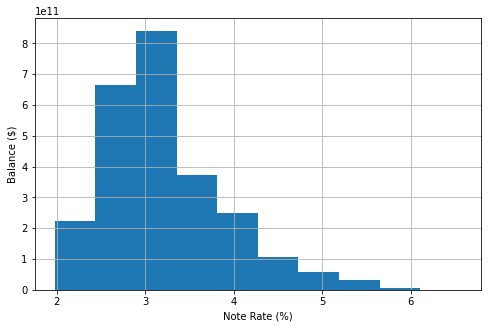

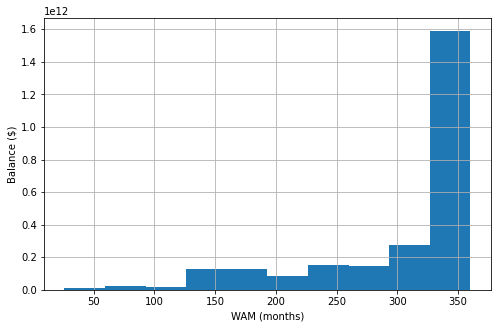

In [ ]:
for v in ['note_rate', 'wam']:
  mbs_data[v].hist(weights=mbs_data['curr_bal'],figsize=(8,5))
  if v=="note_rate":
    plt.xlabel("Note Rate (%)")
  elif v=="wam":
    plt.xlabel("WAM (months)")
  plt.ylabel("Balance ($)")
  plt.show()

# 4. Forecast methodology
Given the complexity of RMBS I make a number of simplifying assumptions to keep the analysis tractable. First I assume each security is homogenous in its contractual features such as note rate, term and remaining maturity. Then I use the weighted average value of each to forecast the scheduled principal and interest payments. Next I assume a static annual prepayment rate (CPR) of 6% for all securities. While this CPR is historically low for agency RMBS it is consistent with [recently observed prepayment rates](https://capitalmarkets.fanniemae.com/media/23091/display). As discussed earlier the Fed's portfolio consists mostly of mortgages with very low rates relative to prevailing mortgage rates. As a result most of these borrowers hold prepayment options that are highly out-of-the-money, providing a strong financial incentive not to prepay. While mortgage rates remain near current levels it is reasonable to expect prepayments on this portfolio to remain at low levels. To evaluate the sensitivity of these results to the prepayment rate assumption, I repeat this analysis assuming a CPR of 10%. 

In [ ]:
def forecast_cashflows(mbs_data, cpr):
  forecast = pd.DataFrame({"t": range(0,max(mbs_data['wam'].astype(int)+1)),
                          "Balance": 0, "int_pymts": 0, "prin_pymts": 0})

  for i in range(len(mbs_data)):
    loan = mbs_data.iloc[i]
    note_rate = loan['note_rate']/1200
    coupon = loan['coupon']/1200
    term = loan['term'].astype(int)
    age = loan['age'].astype(int)
    initial_bal = loan['curr_bal']

    smmfactors = np.power(1-cpr/1200,range(1,term-age+1))
    amfactors = ((1+note_rate)**term - (1+note_rate)**(range(age+1,term+1)))/((1+note_rate)**term - 1)
    initial_amfactor = ((1+note_rate)**term - (1+note_rate)**age)/((1+note_rate)**term - 1)
    amfactors = smmfactors*amfactors/initial_amfactor
    amfactors = np.insert(amfactors,0,1)
    balance = initial_bal*amfactors
    int_pymts = balance[0:-1]*coupon
    prin_pymts = balance[0:-1] - balance[1:]
    
    forecast['Balance'] += np.pad(balance,(0,360-term+age),constant_values=0)
    forecast['int_pymts'] += np.pad(int_pymts,(1,360-term+age),constant_values=0)
    forecast['prin_pymts'] += np.pad(prin_pymts,(1,360-term+age),constant_values=0)

  forecast['bal_frac'] = forecast['Balance']/forecast.iloc[0,1]
  return forecast

mbs_cf = forecast_cashflows(mbs_data, 6)
mbs_cf10 = forecast_cashflows(mbs_data, 10)

# 5. Forecast results
Using the cash flow forecasts I calculate the amount of principal repayment in each month the number of months it will take for 50\% and 95\% of the RMBS portfolio to run off. For now scheduled payments and prepayments are the only sources of runoff for this portfolio. Currently the Fed has indicated they have no plans to consider selling securities.

All portfolio and runoff balances in this section are rescaled to reflect the full portfolio balance.



In [ ]:
def months_to_runoff(cf, pct):
  return min(cf[cf['bal_frac']<pct]['t'])

def plot_balances(cf, title_label):
  runoff_50pct = months_to_runoff(cf, 0.5)
  runoff_75pct = months_to_runoff(cf, 0.25)
  runoff_95pct = months_to_runoff(cf, 0.05)

  asof_date = np.datetime64('2022-10')

  print("\n")
  print("Months to 50% runoff: ", runoff_50pct)
  print("Months to 95% runoff: ", runoff_95pct)
  print("Date of 50% runoff: ", asof_date + np.timedelta64(runoff_50pct,'M'))
  print("Date of 95% runoff: ", asof_date + np.timedelta64(runoff_95pct,'M'))
  print("\n")

  fig, ax = plt.subplots()
  bal_forecast = cf['Balance']/0.95
  bal_forecast.plot(figsize=(13,8),kind='bar',xticks=np.arange(0,361,60),rot=0,width=1)
  ax.set_xticklabels([asof_date+np.timedelta64(m,'M') for m in np.arange(0,361,60)])
  plt.title(title_label)
  plt.xlabel("Forecast date")
  plt.ylabel("Balance remaining ($)")
  plt.axvline(x=runoff_50pct,color='C1',label='50% runoff',linestyle='dashed')
  plt.axvline(x=runoff_95pct,color='C3',label='95% runoff',linestyle='dashed')
  plt.legend()
  plt.show()

def plot_runoff(cf, title_label):

  asof_date = np.datetime64('2022-10')
  runoff_forecast = cf.loc[1:,'prin_pymts']/0.95

  print("\n")
  print("1-year average runoff: ", np.round(np.average(runoff_forecast[0:12]/1000000000),2), "billion")
  print("5-year average runoff: ", np.round(np.average(runoff_forecast[0:60]/1000000000),2), "billion")
  print("\n")

  fig, ax = plt.subplots()
  runoff_forecast.plot(figsize=(13,8),kind='line',xticks=np.arange(0,361,60))
  ax.set_xticklabels([asof_date+np.timedelta64(m,'M') for m in np.arange(0,361,60)])
  plt.title(title_label)
  plt.xlabel("Forecast date")
  plt.ylabel("Monthly runoff ($)")
  plt.legend(["Principal repayment"])
  plt.show()
  

## Baseline forecast
In the baseline forecast I assume the portfolio prepays at 6% CPR. This forecast predicts an average runoff of $19.6 billion over the next year and a portfolio portfolio half-life of 85 months.



1-year average runoff:  19.6 billion
5-year average runoff:  17.08 billion




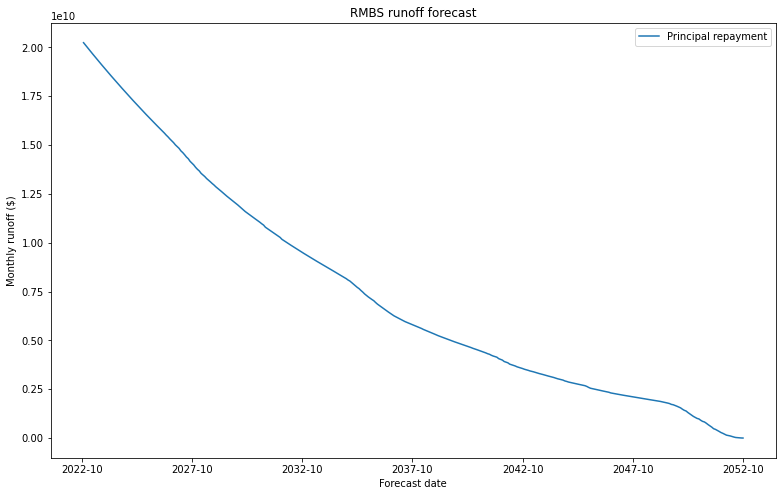

In [ ]:
plot_runoff(mbs_cf, "RMBS runoff forecast")



Months to 50% runoff:  85
Months to 95% runoff:  273
Date of 50% runoff:  2029-11
Date of 95% runoff:  2045-07




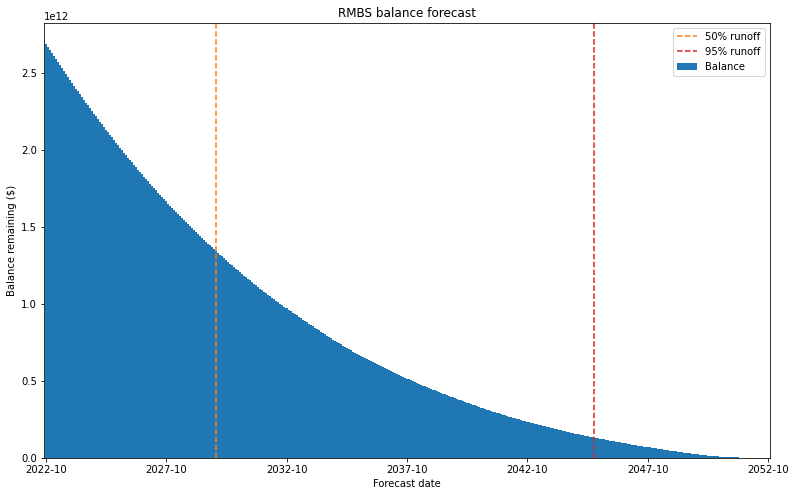

In [ ]:
plot_balances(mbs_cf, "RMBS balance forecast")

## Accelerated prepayment forecast
In the accelerated prepayment forecast I assume the portfolio prepays at 10% CPR. This forecast predicts an average runoff of \$27 billion over the next year and a portfolio portfolio half-life of 62 months.



1-year average runoff:  27.67 billion
5-year average runoff:  22.14 billion




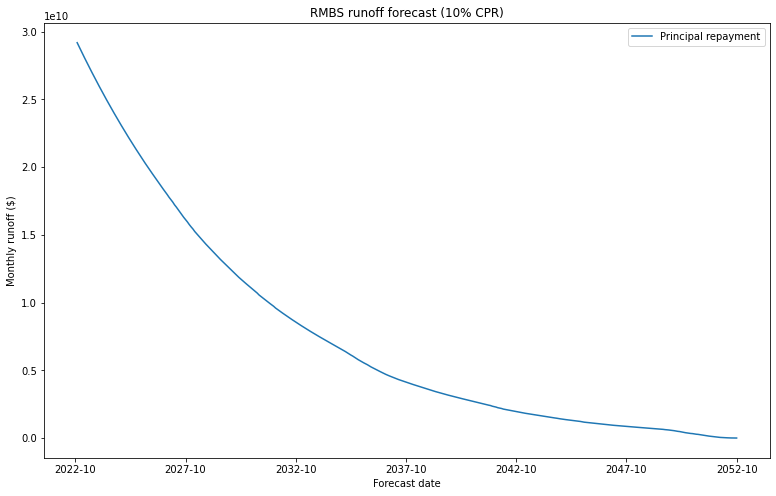

In [ ]:
plot_runoff(mbs_cf10, "RMBS runoff forecast (10% CPR)")



Months to 50% runoff:  62
Months to 95% runoff:  227
Date of 50% runoff:  2027-12
Date of 95% runoff:  2041-09




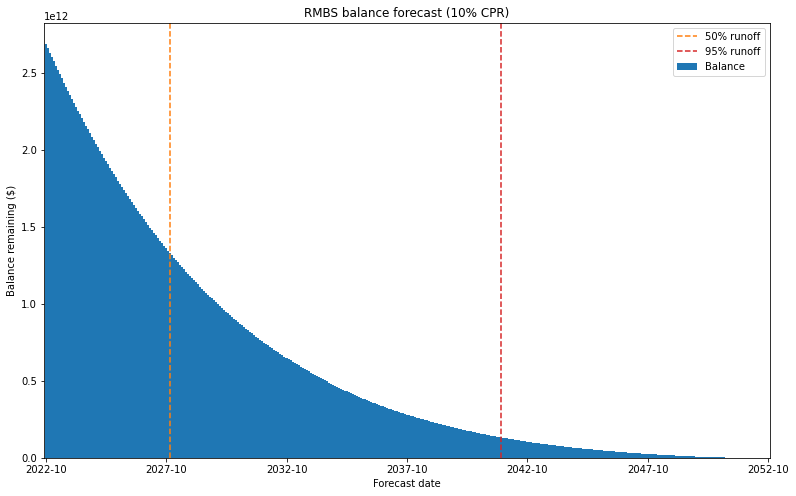

In [ ]:
plot_balances(mbs_cf10, "RMBS balance forecast (10% CPR)")